# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [2]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
about ['surest', 'all-around']
wen ['sword', 'jiang', 'devils', 'on']
entire ['appears', 'blown', 'soundtrack', 'rights']
gray ['offering', 'subtle']
creeped ['against', 'out']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [118]:
num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        '''
        Initializes Word2VecNegativeSampling, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_negative_samples - number of negative samples to generate in addition to a positive one
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        self.num_negative_samples = num_negative_samples

        # TODO: Implement what you need for other methods!
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        
        self.index_by_token = data.index_by_token
        self.token_by_index = data.token_by_index
        
        self.sample = []
        
        for i in range(self.num_contexts):
            center_word, other_words = data.get_random_context(4)
            for word_target in other_words:
                negative = np.random.randint(len(self.token_by_index)-1, size=self.num_negative_samples)
                res = [self.index_by_token[center_word],self.index_by_token[word_target]]
                res.extend(negative)
                self.sample.append(res)
        
        self.output_indices = []
        self.output_target = []
        for _, *lst in self.sample:
            output_indices = np.array(lst)
            output_target = np.zeros(self.num_negative_samples+1)
            output_target[0] =1
            
            self.output_indices.append(torch.tensor(output_indices))
            self.output_target.append(torch.tensor(output_target))
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.sample)

    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - index of the input word (not torch.Tensor!)
        output_indices - torch.Tensor of indices of the target words. Should be 1+num_negative_samples.
        output_target - torch.Tensor with float targets for the training. Should be the same size as output_indices
                        and have 1 for the context word and 0 everywhere else
        '''
        # TODO: Generate tuple of 3 return arguments for i-th sample
        return self.sample[index][0], self.output_indices[index], self.output_target[index], 

dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

dataset = Word2VecNegativeSampling(data, num_negative_samples)
dataset.generate_dataset()

print(len(dataset))

Sample - input: 4010, output indices: tensor([18409,  8997,  5969,  7795,  1085, 17942,  7518, 13784,  9036, 16504,
        10799], dtype=torch.int32), output target: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
82738


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.

In [19]:
ll = nn.Linear(10, 10, bias=False)

In [20]:
ll.weight[0] 

tensor([-0.2935, -0.1323, -0.2824, -0.2054, -0.1403,  0.0118, -0.0785,  0.2338,
         0.2968, -0.0636], grad_fn=<SelectBackward>)

In [18]:
n =  ll.weight[0]  * 2

In [25]:
l = torch.zeros(3)

In [30]:
l[[1,2]] = 1

In [31]:
l

tensor([0., 1., 1.])

In [62]:
from torch.nn.functional import linear
from torch.tensor import new_empty

ImportError: cannot import name 'new_empty' from 'torch.tensor' (C:\ProgramData\Anaconda3\lib\site-packages\torch\tensor.py)

In [45]:
ll = nn.Linear(2, 10, bias=False).float()

In [47]:
out = linear(torch.tensor([1,2]).float(), ll.weight[0:2])

In [51]:
out

tensor([-0.4674,  0.2316], grad_fn=<SqueezeBackward3>)

In [50]:
out.backward(torch.tensor([2,3]).float())

In [119]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()

# As begore, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens):
        super(Word2VecNegativeSamples, self).__init__()
        self.num_tokens = num_tokens
        self.input = nn.Linear(num_tokens, 10, bias=False)
        self.ouput = nn.Linear(10, num_tokens, bias=False)
        
    def forward(self, input_index_batch, output_indices_batch):
        '''
        Implements forward pass with negative sampling
        
        Arguments:
        input_index_batch - Tensor of ints, shape: (batch_size, ), indices of input words in the batch
        output_indices_batch - Tensor if ints, shape: (batch_size, num_negative_samples+1),
                                indices of the target words for every sample
                                
        Returns:
        predictions - Tensor of floats, shape: (batch_size, um_negative_samples+1)
        '''
        
        output_indices_batch = output_indices_batch.long()
        
        tensor = torch.ones(())
        results = tensor.new_empty((output_indices_batch.shape[0], output_indices_batch.shape[1]))

        for i_step, i_word in enumerate(input_index_batch):
            if i_word==19538 :
                i_word = i_word - 1
            a1 = self.input.weight[:, i_word]
            a2 = output_indices_batch[i_step]
            a3=self.ouput.weight[a2]
            out = linear(a1,a3)
            results[i_step]=out
        # TODO Implement forward pass
        # Hint: You can use for loop to go over all samples on the batch,
        # run every sample indivisually and then use
        # torch.stack or torch.cat to produce the final result
        return results
    
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.FloatTensor)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (ouput): Linear(in_features=10, out_features=19538, bias=False)
)

In [92]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [120]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    return nn_model.input.weight.transpose(0, 1), nn_model.ouput.weight

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [128]:
def train_neg_sample(model, dataset, train_loader, optimizer, scheduler, num_epochs):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    model = model.to(device)

    loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()

        model.train() # Enter train mode
        
        dataset.generate_dataset() # Regenerate dataset every epoch
        
        loss_accum = 0
        total_samples = 0
        correct_samples = 0
        
    
        for i_step, (input_vector, output_indices, output_target) in enumerate(train_loader):
            prediction = model(input_vector.to(device), output_indices.to(device))
            loss_value = loss(prediction.to(device).float(), output_target.to(device).float())
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_accum += loss_value
            
            correct_samples += torch.sum((prediction>0.5) == output_target.byte())
            total_samples = total_samples + 1
            
        train_accuracy = float(correct_samples) / total_samples

        ave_loss = loss_accum / total_samples
        
        at(ave_loss))
        train_history.append(train_accuracy)


        # TODO: Implement training using negative samples
        # You can estimate accuracy by comparing prediction values with 0.5
        # And don't forget to step the scheduler!
        
        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [130]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.Adam(nn_model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Average loss: 0.530015, Train accuracy: 199.512307
Average loss: 0.357208, Train accuracy: 199.992988
Average loss: 0.349839, Train accuracy: 199.238957
Average loss: 0.351170, Train accuracy: 198.223538
Average loss: 0.335880, Train accuracy: 198.530632
Average loss: 0.324471, Train accuracy: 198.955818
Average loss: 0.326371, Train accuracy: 198.448176
Average loss: 0.328127, Train accuracy: 198.198157
Average loss: 0.309593, Train accuracy: 198.888916
Average loss: 0.302594, Train accuracy: 199.237600


In [135]:
loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Average loss: 0.302818, Train accuracy: 199.134300
Average loss: 0.302504, Train accuracy: 199.117775
Average loss: 0.290267, Train accuracy: 199.590469
Average loss: 0.283558, Train accuracy: 199.906348
Average loss: 0.281252, Train accuracy: 199.975097
Average loss: 0.282269, Train accuracy: 199.874940
Average loss: 0.271122, Train accuracy: 200.260608
Average loss: 0.264980, Train accuracy: 200.658696
Average loss: 0.263713, Train accuracy: 200.703650
Average loss: 0.264832, Train accuracy: 200.577686


In [136]:
loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Average loss: 0.256405, Train accuracy: 200.906708
Average loss: 0.250558, Train accuracy: 201.152748
Average loss: 0.250300, Train accuracy: 201.194109
Average loss: 0.249229, Train accuracy: 201.168518
Average loss: 0.243442, Train accuracy: 201.399613
Average loss: 0.239796, Train accuracy: 201.497096
Average loss: 0.237542, Train accuracy: 201.572982
Average loss: 0.236941, Train accuracy: 201.609420
Average loss: 0.233110, Train accuracy: 201.671898
Average loss: 0.230475, Train accuracy: 201.743794


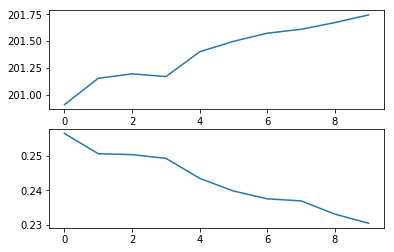

In [137]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

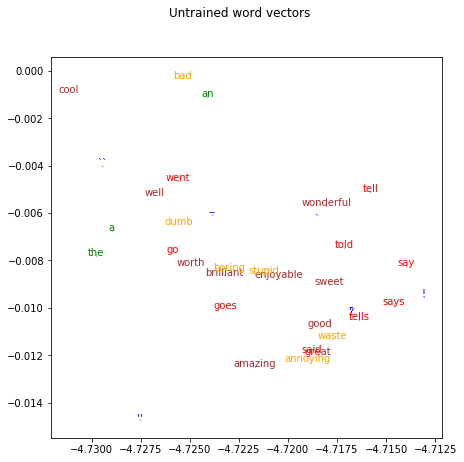

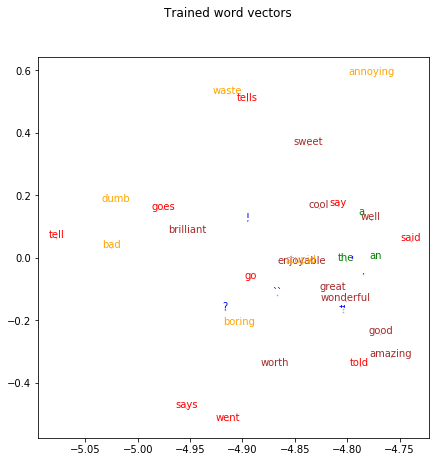

In [138]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors.cpu(), output_vectors.cpu()), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")